# Word Level Federated Text Generation with Stack Overflow
- Joel Stremmel
- 01-28-20

**About:**

This notebook loads the Stack Overflow data available through `tff.simulation.datasets` and trains an LSTM model with Federared Averaging by following the Federated Learning for Text Generation [example notebook](https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb).

**Notes:**

- This notebook prepares the Stack Overflow dataset for word level language modeling using this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/dataset.py
).
- The metrics for model training come from this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/metrics.py). 


**Data:** 
- https://www.kaggle.com/stackoverflow/stackoverflow

**License:** 
- https://creativecommons.org/licenses/by-sa/3.0/

**Data and Model References:**
- https://www.tensorflow.org/federated/api_docs/python/tff/simulation/datasets/stackoverflow/load_data
- https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb
- https://github.com/tensorflow/federated/
- https://github.com/tensorflow/federated/tree/master/tensorflow_federated/python/research/baselines/stackoverflow
- https://www.tensorflow.org/tutorials/text/text_generation
- https://ruder.io/deep-learning-nlp-best-practices/

**Environment Setup References:**
- https://www.tensorflow.org/install/gpu
- https://gist.github.com/matheustguimaraes/43e0b65aa534db4df2918f835b9b361d
- https://www.tensorflow.org/install/source#tested_build_configurations
- https://anbasile.github.io/programming/2017/06/25/jupyter-venv/

### Environment Setup
Pip install these packages in the order listed.

In [1]:
# !pip install --upgrade pip
# !pip install --upgrade tensorflow-federated
# !pip uninstall tensorflow -y
# !pip install --upgrade tensorflow-gpu==2.0
# !pip install --upgrade nltk
# !pip install matplotlib
# !pip install nest_asyncio

### Imports

In [2]:
import nest_asyncio
nest_asyncio.apply()

In [3]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

In [4]:
# from https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/dataset.py
from utils.dataset import construct_word_level_datasets, get_vocab, get_special_tokens

# from https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/metrics.py
import utils.metrics as metrics

In [5]:
import collections
import functools
import six
import time
import string

import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

import tensorflow as tf
import tensorflow_federated as tff

### Set Compatability Behavior

In [6]:
tf.compat.v1.enable_v2_behavior()

### Check Tensorflow Install

In [7]:
print('Built with Cuda: {}'.format(tf.test.is_built_with_cuda()))
print('Build with GPU support: {}'.format(tf.test.is_built_with_gpu_support()))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Built with Cuda: True
Build with GPU support: True
Num GPUs Available:  1


### Set Tensorflow to Use GPU

In [8]:
physical_devices = tf.config.experimental.list_physical_devices(device_type=None)
tf.config.experimental.set_memory_growth(physical_devices[-1], enable=True)
for device in physical_devices:
    print(device)

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')
PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### Test TFF

In [9]:
tff.federated_computation(lambda: 'Hello, World!')()

'Hello, World!'

### Set Some Parameters for Preprocessing the Data and Training the Model
**Note:** Ask Keith how he's been setting there for internal experiments.

In [10]:
VOCAB_SIZE = 5000
BATCH_SIZE = 16
CLIENTS_EPOCHS_PER_ROUND = 1
MAX_SEQ_LENGTH = 20
MAX_ELEMENTS_PER_USER = 500
CENTRALIZED_TRAIN = False
SHUFFLE_BUFFER_SIZE = 1000
NUM_VALIDATION_EXAMPLES = 2000
NUM_TEST_EXAMPLES = 2

NUM_ROUNDS = 50
NUM_TRAIN_CLIENTS = 10
UNIFORM_WEIGHTING = False

### Load and Preprocess Word Level Datasets

In [11]:
train_data, val_data, test_data = construct_word_level_datasets(
    vocab_size=VOCAB_SIZE,
    batch_size=BATCH_SIZE,
    client_epochs_per_round=CLIENTS_EPOCHS_PER_ROUND,
    max_seq_len=MAX_SEQ_LENGTH,
    max_elements_per_user=MAX_ELEMENTS_PER_USER,
    centralized_train=CENTRALIZED_TRAIN,
    shuffle_buffer_size=SHUFFLE_BUFFER_SIZE,
    num_validation_examples=NUM_VALIDATION_EXAMPLES,
    num_test_examples=NUM_TEST_EXAMPLES)

/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


### Retrieve the Dataset Vocab

In [12]:
vocab = get_vocab(VOCAB_SIZE)

### Retrieve the Special Characters Created During Preprocessing
The four special tokens are:
- pad: padding token
- oov: out of vocabulary
- bos: begin of sentence
- eos: end of sentence

In [13]:
pad, oov, bos, eos = get_special_tokens(VOCAB_SIZE)

In [14]:
special2idx = dict(zip(['pad', 'oov', 'bos', 'eos'], [pad, oov, bos, eos]))
idx2special = {v:k for k, v in special2idx.items()}

### Set Vocabulary
Add one to account for the pad token which has idx 0.

In [15]:
word2idx = {word:i+1 for i, word in enumerate(vocab)}
idx2word = {i+1:word for i, word in enumerate(vocab)}

### Add Special Characters

In [16]:
word2idx = {**word2idx, **special2idx}
idx2word = {**idx2word, **idx2special}

### Reset Vocab Size
This accounts for having added the special characters.

In [17]:
EXTENDED_VOCAB_SIZE = VOCAB_SIZE + len(special2idx)

### Define Function to Build Model

In [18]:
def build_model(embedding_dim=256, rnn_units=512):
    """
    Build model with architecture from: https://www.tensorflow.org/tutorials/text/text_generation.
    """

    model1_input = tf.keras.Input(shape=(None, ), # changed from MAX_SEQ_LENGTH
                                  name='model1_input')
    
    model1_embedding = tf.keras.layers.Embedding(input_dim=EXTENDED_VOCAB_SIZE,
                                                 output_dim=embedding_dim,
                                                 #input_length=MAX_SEQ_LENGTH,
                                                 #batch_input_shape=[BATCH_SIZE, None],
                                                 mask_zero=True,
                                                 name='model1_embedding')(model1_input)
    
    model1_lstm = tf.keras.layers.LSTM(units=rnn_units,
                                       return_sequences=True,
                                       recurrent_initializer='glorot_uniform',
                                       name='model1_lstm')(model1_embedding)
    
    model1_dense1 = tf.keras.layers.Dense(units=embedding_dim)(model1_lstm)
    
    model1_dense2 = tf.keras.layers.Dense(units=EXTENDED_VOCAB_SIZE)(model1_dense1)
    
    final_model = tf.keras.Model(inputs=model1_input, outputs=model1_dense2)
                 
    return final_model

### Define the Text Generation Strategy

In [19]:
def generate_text(model, start_string):
    """
    Generate text by sampling from the model output distribution
    as in From https://www.tensorflow.org/tutorials/sequences/text_generation.
    """
    
    start_words = [word.lower() for word in start_string.split(' ')]

    num_generate = 50
    input_eval = [word2idx[word] for word in start_words]
    input_eval = tf.expand_dims(input_eval, 0)
    text_generated = []
    temperature = 1.0

    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()
        input_eval = tf.expand_dims([predicted_id], 0)
        text_generated.append(idx2word[predicted_id])

    return (' '.join(start_words) + ' '.join(text_generated))

### Load or Build the Model and Try Generating Some Text

In [20]:
keras_model = build_model()
print(generate_text(keras_model, "How are you today"))

how are you todayreadability meant trim parameter pressing ui asked feel criteria score concise scripts javadoc reusable invoking helps edited twitter communicating step referring completion tend assumed capturing rendered impossible updated limiting ? calls dragged categories symbols ` whilst needed reset expanded / history language clauses moment tap getting reusable optimization hasn't coupled


### Define Evaluation Metrics for Training

In [21]:
def get_metrics():
    
    evaluation_metrics = [
        metrics.NumTokensCounter(name='num_tokens', masked_tokens=[pad]),
        metrics.NumTokensCounter(name='num_tokens_no_oov', masked_tokens=[pad, oov]),
        metrics.NumBatchesCounter(name='num_batches'),
        metrics.NumExamplesCounter(name='num_examples'),
        metrics.MaskedCategoricalAccuracy(name='accuracy', masked_tokens=[pad]),
        metrics.MaskedCategoricalAccuracy(name='accuracy_no_oov', masked_tokens=[pad, oov]),
        metrics.MaskedCategoricalAccuracy(name='accuracy_no_oov_no_eos', masked_tokens=[pad, oov, eos])
    ]

#     evaluation_metrics = ['accuracy']
    
    return evaluation_metrics

### Define a Function to Compile the Model for Training

In [22]:
def compile_model(keras_model, evaluation_metrics):
    
    keras_model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=evaluation_metrics)
    
    return keras_model

### Create TFF Version of the Model to be Trained with Federated Averaging
- TFF uses a sample batch so it knows the types and shapes that your model expects.
- The model function then builds and compiles the model and creates a TFF version to be trained.

In [23]:
sample_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(val_data)))

/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


In [24]:
def model_fn():
    """
    Create TFF model from compiled Keras model and a sample batch.
    """
    
    keras_model = build_model()
    evaluation_metrics = get_metrics()
    
    compile_model(keras_model, evaluation_metrics)
    
    return tff.learning.from_compiled_keras_model(keras_model, sample_batch)

### Define Model History Tracker to Save Traindand Validation Metrics at Each Training Round
This is a spin off of [keras' model history](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History) but is specific to the TFF training code used here.

In [25]:
class model_history_tracker:
    
    def __init__(self, metric_names=[]):
        
        self.metric_names = metric_names
        self.metrics_dict = {name:[] for name in metric_names}
    
    def get_metrics_by_name(self, metric_name):
        
        return self.metrics_dict[metric_name]
    
    def add_metrics_by_name(self, metric_name, metric_result):
        
        self.metrics_dict[metric_name].append(metric_result) 

### Initialize Train and Validation Model Trackers to be Used Below

In [26]:
evaluation_metric_names = ['loss',
                           'num_tokens',
                           'num_tokens_no_oov',
                           'num_batches',
                           'num_examples',
                           'accuracy',
                           'accuracy_no_oov',
                           'accuracy_no_oov_no_oes']

# evaluation_metric_names = ['loss', 'accuracy']

train_metrics_tracker = model_history_tracker(evaluation_metric_names)
val_metrics_tracker = model_history_tracker(evaluation_metric_names)

In [27]:
val_metrics_tracker.metric_names

['loss',
 'num_tokens',
 'num_tokens_no_oov',
 'num_batches',
 'num_examples',
 'accuracy',
 'accuracy_no_oov',
 'accuracy_no_oov_no_oes']

### Define Function to Evaluate Model Performance on Validation Data

In [28]:
def keras_evaluate(state, val_dataset):
    
    keras_model = build_model()
    evaluation_metrics = get_metrics()
    
    compile_model(keras_model, evaluation_metrics)
    tff.learning.assign_weights_to_keras_model(keras_model, state.model)
    
    evaluation_results = keras_model.evaluate(val_dataset)
    
    for i, result in enumerate(evaluation_results):
        val_metrics_tracker.add_metrics_by_name(val_metrics_tracker.metric_names[i], result)

### Define Function to Weight Clients Uniformly or by Number of Tokens

In [29]:
def client_weight_fn(local_outputs):
    
    num_tokens = tf.cast(tf.squeeze(local_outputs['num_tokens']), tf.float32)
    
    return 1.0 if UNIFORM_WEIGHTING else num_tokens

### Define Function to Supply Server Optimizer

In [30]:
def server_optimizer_fn():
    
    return tf.keras.optimizers.Adam()

### Set the Default Executor

In [31]:
tff.framework.set_default_executor(tff.framework.create_local_executor(max_fanout=10))

### Create an Iterative Process

In [32]:
iterative_process = (
      tff.learning.federated_averaging.build_federated_averaging_process(
          model_fn=model_fn,
          server_optimizer_fn=server_optimizer_fn,
          client_weight_fn=client_weight_fn))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Initalize the Process
Server state will be updated in the training loop.

In [33]:
server_state = iterative_process.initialize()

### Define Function to Create Training Datsets from Randomly Sampled Clients

In [34]:
def get_sample_clients(dataset, num_clients):
    
    random_indices = np.random.choice(len(dataset.client_ids), size=num_clients, replace=False)
    
    return np.array(dataset.client_ids)[random_indices]

### Train Model Across Many Randomly Sampled Clients with Federated Averaging

In [35]:
for round_num in range(0, NUM_ROUNDS):
    
    # Examine validation metrics
    print(f'Evaluating before training round #{round_num} on {NUM_VALIDATION_EXAMPLES} clients.')
    keras_evaluate(server_state, val_data)
    
    # Sample train clients to create a train dataset
    print(f'Sampling {NUM_TRAIN_CLIENTS} new clients.')
    train_clients = get_sample_clients(train_data, num_clients=NUM_TRAIN_CLIENTS)
    train_datasets = [train_data.create_tf_dataset_for_client(client) for client in train_clients]
    
    # Apply federated training round
    server_state, server_metrics = iterative_process.next(server_state, train_datasets)
    
    # Examine training metrics
    print('Round: {}'.format(round_num))
    print('   Loss: {:.8f}'.format(server_metrics.loss))
    print('   num_batches: {}'.format(server_metrics.num_batches))
    print('   num_examples: {}'.format(server_metrics.num_examples))
    print('   num_tokens: {}'.format(server_metrics.num_tokens))
    print('   num_tokens_no_oov: {}'.format(server_metrics.num_tokens_no_oov))
    print('   accuracy: {:.5f}'.format(server_metrics.accuracy))
    print('   accuracy_no_oov: {:.5f}'.format(server_metrics.accuracy_no_oov))
    
    # Add train metrics to tracker
    train_metrics_tracker.add_metrics_by_name('loss', server_metrics.loss)
    train_metrics_tracker.add_metrics_by_name('accuracy', server_metrics.accuracy)

Evaluating before training round #0 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 262ms/step - loss: 6.0181 - num_tokens: 26900.0000 - num_tokens_no_oov: 25522.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 1.8587e-04 - accuracy_no_oov: 1.9591e-04 - accuracy_no_oov_no_eos: 2.0746e-04
Sampling 10 new clients.
Round: 0
   Loss: 7.14422512
   num_batches: 150
   num_examples: 2302
   num_tokens: 30529
   num_tokens_no_oov: 29200
   accuracy: 0.00183
   accuracy_no_oov: 0.00192
Evaluating before training round #1 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 236ms/step - loss: 5.7634 - num_tokens: 25578.0000 - num_tokens_no_oov: 24432.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 1.1729e-04 - accuracy_no_oov: 1.2279e-04 - accuracy_no_oov_no_eos: 1.3110e-04
Sampling 10 new clients.
Round: 1
   Loss: 6.72113609
   num_batches: 142
   num_examples: 2206
   num_tokens: 29441
   num_tokens_no_oov: 28379
   accuracy: 0.00003
   accuracy_no_oov: 0.00004
Evaluating before training round #2 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 247ms/step - loss: 6.2050 - num_tokens: 27868.0000 - num_tokens_no_oov: 26327.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 2
   Loss: 6.22485590
   num_batches: 143
   num_examples: 2213
   num_tokens: 27997
   num_tokens_no_oov: 26830
   accuracy: 0.00221
   accuracy_no_oov: 0.00231
Evaluating before training round #3 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 243ms/step - loss: 6.2131 - num_tokens: 27969.0000 - num_tokens_no_oov: 26472.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 3
   Loss: 5.92745161
   num_batches: 169
   num_examples: 2605
   num_tokens: 35907
   num_tokens_no_oov: 34146
   accuracy: 0.00259
   accuracy_no_oov: 0.00062
Evaluating before training round #4 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 241ms/step - loss: 6.1388 - num_tokens: 27868.0000 - num_tokens_no_oov: 26269.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 4
   Loss: 5.34321165
   num_batches: 174
   num_examples: 2713
   num_tokens: 34689
   num_tokens_no_oov: 32990
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #5 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 257ms/step - loss: 5.7788 - num_tokens: 26642.0000 - num_tokens_no_oov: 25384.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 5
   Loss: 5.04021311
   num_batches: 167
   num_examples: 2594
   num_tokens: 32747
   num_tokens_no_oov: 31050
   accuracy: 0.00266
   accuracy_no_oov: 0.00000
Evaluating before training round #6 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 254ms/step - loss: 5.5330 - num_tokens: 26351.0000 - num_tokens_no_oov: 24900.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 6
   Loss: 5.22564602
   num_batches: 134
   num_examples: 2078
   num_tokens: 27451
   num_tokens_no_oov: 26220
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #7 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 248ms/step - loss: 5.3315 - num_tokens: 26273.0000 - num_tokens_no_oov: 24968.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 7
   Loss: 4.97770929
   num_batches: 184
   num_examples: 2851
   num_tokens: 39008
   num_tokens_no_oov: 37164
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #8 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 242ms/step - loss: 5.1894 - num_tokens: 26565.0000 - num_tokens_no_oov: 25203.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 8
   Loss: 4.70807314
   num_batches: 170
   num_examples: 2652
   num_tokens: 34264
   num_tokens_no_oov: 32913
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #9 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 258ms/step - loss: 5.2029 - num_tokens: 27600.0000 - num_tokens_no_oov: 26347.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 9
   Loss: 4.98468399
   num_batches: 155
   num_examples: 2408
   num_tokens: 33975
   num_tokens_no_oov: 32417
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #10 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 255ms/step - loss: 4.9607 - num_tokens: 27084.0000 - num_tokens_no_oov: 25671.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 10
   Loss: 4.44707298
   num_batches: 162
   num_examples: 2497
   num_tokens: 32377
   num_tokens_no_oov: 30802
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #11 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 260ms/step - loss: 4.8971 - num_tokens: 27490.0000 - num_tokens_no_oov: 26064.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 11
   Loss: 4.46758509
   num_batches: 161
   num_examples: 2497
   num_tokens: 32937
   num_tokens_no_oov: 31121
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #12 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 253ms/step - loss: 4.7863 - num_tokens: 27669.0000 - num_tokens_no_oov: 26339.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 12
   Loss: 4.45378971
   num_batches: 113
   num_examples: 1710
   num_tokens: 22716
   num_tokens_no_oov: 21392
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #13 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 247ms/step - loss: 4.3669 - num_tokens: 25510.0000 - num_tokens_no_oov: 24404.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 13
   Loss: 4.31595325
   num_batches: 144
   num_examples: 2218
   num_tokens: 29095
   num_tokens_no_oov: 27591
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #14 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 249ms/step - loss: 4.2811 - num_tokens: 25634.0000 - num_tokens_no_oov: 24305.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 14
   Loss: 4.54188442
   num_batches: 84
   num_examples: 1287
   num_tokens: 17520
   num_tokens_no_oov: 16663
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #15 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 247ms/step - loss: 4.3082 - num_tokens: 26093.0000 - num_tokens_no_oov: 24720.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 15
   Loss: 4.39264250
   num_batches: 169
   num_examples: 2610
   num_tokens: 35857
   num_tokens_no_oov: 34236
   accuracy: 0.00003
   accuracy_no_oov: 0.00003
Evaluating before training round #16 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 253ms/step - loss: 4.2143 - num_tokens: 25854.0000 - num_tokens_no_oov: 24842.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 16
   Loss: 4.39349270
   num_batches: 173
   num_examples: 2676
   num_tokens: 37165
   num_tokens_no_oov: 35622
   accuracy: 0.00016
   accuracy_no_oov: 0.00017
Evaluating before training round #17 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 251ms/step - loss: 4.2737 - num_tokens: 26313.0000 - num_tokens_no_oov: 25018.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 17
   Loss: 4.09139681
   num_batches: 186
   num_examples: 2884
   num_tokens: 37813
   num_tokens_no_oov: 35997
   accuracy: 0.00140
   accuracy_no_oov: 0.00147
Evaluating before training round #18 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 247ms/step - loss: 4.3557 - num_tokens: 26907.0000 - num_tokens_no_oov: 25831.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 18
   Loss: 4.22266865
   num_batches: 165
   num_examples: 2563
   num_tokens: 34544
   num_tokens_no_oov: 32740
   accuracy: 0.00342
   accuracy_no_oov: 0.00360
Evaluating before training round #19 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 255ms/step - loss: 4.3705 - num_tokens: 27268.0000 - num_tokens_no_oov: 25999.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 19
   Loss: 4.27786684
   num_batches: 136
   num_examples: 2086
   num_tokens: 28262
   num_tokens_no_oov: 26833
   accuracy: 0.00626
   accuracy_no_oov: 0.00291
Evaluating before training round #20 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 249ms/step - loss: 4.1956 - num_tokens: 26044.0000 - num_tokens_no_oov: 25004.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 20
   Loss: 4.26857615
   num_batches: 135
   num_examples: 2091
   num_tokens: 28451
   num_tokens_no_oov: 27012
   accuracy: 0.00415
   accuracy_no_oov: 0.00437
Evaluating before training round #21 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 235ms/step - loss: 4.1946 - num_tokens: 26352.0000 - num_tokens_no_oov: 25099.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 21
   Loss: 3.82550931
   num_batches: 162
   num_examples: 2522
   num_tokens: 32033
   num_tokens_no_oov: 30542
   accuracy: 0.01626
   accuracy_no_oov: 0.01683
Evaluating before training round #22 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 263ms/step - loss: 4.2163 - num_tokens: 26557.0000 - num_tokens_no_oov: 25262.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 22
   Loss: 4.30378199
   num_batches: 133
   num_examples: 2069
   num_tokens: 28743
   num_tokens_no_oov: 27643
   accuracy: 0.00713
   accuracy_no_oov: 0.00622
Evaluating before training round #23 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 232ms/step - loss: 4.2919 - num_tokens: 26848.0000 - num_tokens_no_oov: 25780.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 23
   Loss: 4.03478241
   num_batches: 127
   num_examples: 1917
   num_tokens: 24891
   num_tokens_no_oov: 23651
   accuracy: 0.00828
   accuracy_no_oov: 0.00837
Evaluating before training round #24 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 248ms/step - loss: 4.2657 - num_tokens: 26735.0000 - num_tokens_no_oov: 25219.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 24
   Loss: 4.08157253
   num_batches: 146
   num_examples: 2245
   num_tokens: 30232
   num_tokens_no_oov: 28867
   accuracy: 0.01561
   accuracy_no_oov: 0.01632
Evaluating before training round #25 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 259ms/step - loss: 4.1634 - num_tokens: 26208.0000 - num_tokens_no_oov: 24832.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 25
   Loss: 3.99316621
   num_batches: 212
   num_examples: 3318
   num_tokens: 44328
   num_tokens_no_oov: 42252
   accuracy: 0.02734
   accuracy_no_oov: 0.02161
Evaluating before training round #26 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 244ms/step - loss: 4.4252 - num_tokens: 27812.0000 - num_tokens_no_oov: 26676.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 26
   Loss: 4.14234877
   num_batches: 151
   num_examples: 2348
   num_tokens: 32363
   num_tokens_no_oov: 30907
   accuracy: 0.01684
   accuracy_no_oov: 0.01576
Evaluating before training round #27 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 255ms/step - loss: 4.0912 - num_tokens: 25997.0000 - num_tokens_no_oov: 24700.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 7.6932e-05 - accuracy_no_oov: 8.0972e-05 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 27
   Loss: 3.89095187
   num_batches: 138
   num_examples: 2130
   num_tokens: 27572
   num_tokens_no_oov: 26211
   accuracy: 0.01919
   accuracy_no_oov: 0.02018
Evaluating before training round #28 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 256ms/step - loss: 4.3880 - num_tokens: 27862.0000 - num_tokens_no_oov: 26518.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0025 - accuracy_no_oov: 0.0027 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 28
   Loss: 4.02617598
   num_batches: 208
   num_examples: 3222
   num_tokens: 43671
   num_tokens_no_oov: 41605
   accuracy: 0.03208
   accuracy_no_oov: 0.02348
Evaluating before training round #29 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 244ms/step - loss: 4.3290 - num_tokens: 27564.0000 - num_tokens_no_oov: 26339.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0200 - accuracy_no_oov: 0.0209 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 29
   Loss: 3.85938072
   num_batches: 119
   num_examples: 1818
   num_tokens: 23410
   num_tokens_no_oov: 22375
   accuracy: 0.02486
   accuracy_no_oov: 0.02467
Evaluating before training round #30 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 252ms/step - loss: 3.8921 - num_tokens: 24981.0000 - num_tokens_no_oov: 23612.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0443 - accuracy_no_oov: 0.0469 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 30
   Loss: 4.09939241
   num_batches: 120
   num_examples: 1827
   num_tokens: 25115
   num_tokens_no_oov: 23837
   accuracy: 0.04117
   accuracy_no_oov: 0.02509
Evaluating before training round #31 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 265ms/step - loss: 3.7911 - num_tokens: 24415.0000 - num_tokens_no_oov: 23159.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0539 - accuracy_no_oov: 0.0569 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 31
   Loss: 3.84604955
   num_batches: 121
   num_examples: 1851
   num_tokens: 23768
   num_tokens_no_oov: 22521
   accuracy: 0.04426
   accuracy_no_oov: 0.03836
Evaluating before training round #32 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 245ms/step - loss: 3.7436 - num_tokens: 24470.0000 - num_tokens_no_oov: 23260.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0583 - accuracy_no_oov: 0.0613 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 32
   Loss: 4.10761642
   num_batches: 174
   num_examples: 2686
   num_tokens: 36963
   num_tokens_no_oov: 35415
   accuracy: 0.04180
   accuracy_no_oov: 0.03973
Evaluating before training round #33 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 254ms/step - loss: 4.0655 - num_tokens: 26412.0000 - num_tokens_no_oov: 25120.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0518 - accuracy_no_oov: 0.0545 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 33
   Loss: 3.68809009
   num_batches: 209
   num_examples: 3264
   num_tokens: 41336
   num_tokens_no_oov: 39487
   accuracy: 0.05888
   accuracy_no_oov: 0.05587
Evaluating before training round #34 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 258ms/step - loss: 4.0689 - num_tokens: 26769.0000 - num_tokens_no_oov: 25153.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0523 - accuracy_no_oov: 0.0556 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 34
   Loss: 4.19481134
   num_batches: 164
   num_examples: 2553
   num_tokens: 36196
   num_tokens_no_oov: 34456
   accuracy: 0.05020
   accuracy_no_oov: 0.03219
Evaluating before training round #35 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 252ms/step - loss: 4.1269 - num_tokens: 27104.0000 - num_tokens_no_oov: 25850.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0524 - accuracy_no_oov: 0.0549 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 35
   Loss: 3.94099331
   num_batches: 181
   num_examples: 2829
   num_tokens: 37868
   num_tokens_no_oov: 36034
   accuracy: 0.05958
   accuracy_no_oov: 0.04873
Evaluating before training round #36 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 257ms/step - loss: 4.0073 - num_tokens: 26222.0000 - num_tokens_no_oov: 24781.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0567 - accuracy_no_oov: 0.0600 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 36
   Loss: 3.73989868
   num_batches: 145
   num_examples: 2246
   num_tokens: 29005
   num_tokens_no_oov: 27814
   accuracy: 0.05802
   accuracy_no_oov: 0.05325
Evaluating before training round #37 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 244ms/step - loss: 3.6755 - num_tokens: 24322.0000 - num_tokens_no_oov: 23268.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0629 - accuracy_no_oov: 0.0657 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 37
   Loss: 3.79513717
   num_batches: 134
   num_examples: 2080
   num_tokens: 27100
   num_tokens_no_oov: 25732
   accuracy: 0.06041
   accuracy_no_oov: 0.04772
Evaluating before training round #38 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 255ms/step - loss: 4.0404 - num_tokens: 26511.0000 - num_tokens_no_oov: 25105.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0565 - accuracy_no_oov: 0.0597 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 38
   Loss: 3.90353942
   num_batches: 187
   num_examples: 2903
   num_tokens: 38946
   num_tokens_no_oov: 37089
   accuracy: 0.06237
   accuracy_no_oov: 0.04894
Evaluating before training round #39 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 266ms/step - loss: 3.8603 - num_tokens: 25256.0000 - num_tokens_no_oov: 24079.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0563 - accuracy_no_oov: 0.0591 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 39
   Loss: 3.90863967
   num_batches: 187
   num_examples: 2902
   num_tokens: 39212
   num_tokens_no_oov: 37672
   accuracy: 0.05866
   accuracy_no_oov: 0.05118
Evaluating before training round #40 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 252ms/step - loss: 4.1897 - num_tokens: 27540.0000 - num_tokens_no_oov: 26421.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0513 - accuracy_no_oov: 0.0534 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 40
   Loss: 3.99960709
   num_batches: 203
   num_examples: 3156
   num_tokens: 43990
   num_tokens_no_oov: 42015
   accuracy: 0.06804
   accuracy_no_oov: 0.05134
Evaluating before training round #41 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 6s 278ms/step - loss: 4.0492 - num_tokens: 26171.0000 - num_tokens_no_oov: 24937.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0564 - accuracy_no_oov: 0.0592 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 41
   Loss: 3.77455044
   num_batches: 158
   num_examples: 2455
   num_tokens: 31899
   num_tokens_no_oov: 30523
   accuracy: 0.06815
   accuracy_no_oov: 0.05596
Evaluating before training round #42 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 261ms/step - loss: 4.0843 - num_tokens: 26299.0000 - num_tokens_no_oov: 24996.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0562 - accuracy_no_oov: 0.0587 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 42
   Loss: 3.87147546
   num_batches: 203
   num_examples: 3151
   num_tokens: 41558
   num_tokens_no_oov: 39518
   accuracy: 0.07236
   accuracy_no_oov: 0.05276
Evaluating before training round #43 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 244ms/step - loss: 4.2053 - num_tokens: 27156.0000 - num_tokens_no_oov: 25534.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0666 - accuracy_no_oov: 0.0563 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 43
   Loss: 3.96297836
   num_batches: 145
   num_examples: 2236
   num_tokens: 30204
   num_tokens_no_oov: 28829
   accuracy: 0.06565
   accuracy_no_oov: 0.04985
Evaluating before training round #44 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 250ms/step - loss: 3.9946 - num_tokens: 25910.0000 - num_tokens_no_oov: 24560.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0766 - accuracy_no_oov: 0.0618 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 44
   Loss: 3.81805277
   num_batches: 177
   num_examples: 2759
   num_tokens: 36335
   num_tokens_no_oov: 34394
   accuracy: 0.08028
   accuracy_no_oov: 0.05882
Evaluating before training round #45 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 249ms/step - loss: 4.0370 - num_tokens: 25889.0000 - num_tokens_no_oov: 24711.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0745 - accuracy_no_oov: 0.0582 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 45
   Loss: 4.00382090
   num_batches: 204
   num_examples: 3196
   num_tokens: 45011
   num_tokens_no_oov: 42973
   accuracy: 0.07847
   accuracy_no_oov: 0.05971
Evaluating before training round #46 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 247ms/step - loss: 4.1190 - num_tokens: 26695.0000 - num_tokens_no_oov: 25215.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0888 - accuracy_no_oov: 0.0560 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 46
   Loss: 3.68594003
   num_batches: 157
   num_examples: 2414
   num_tokens: 30980
   num_tokens_no_oov: 29469
   accuracy: 0.08886
   accuracy_no_oov: 0.06831
Evaluating before training round #47 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 259ms/step - loss: 3.9945 - num_tokens: 25908.0000 - num_tokens_no_oov: 24509.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0908 - accuracy_no_oov: 0.0574 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 47
   Loss: 3.86341953
   num_batches: 175
   num_examples: 2711
   num_tokens: 35814
   num_tokens_no_oov: 34078
   accuracy: 0.08262
   accuracy_no_oov: 0.06027
Evaluating before training round #48 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 246ms/step - loss: 3.7455 - num_tokens: 24578.0000 - num_tokens_no_oov: 23401.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0928 - accuracy_no_oov: 0.0631 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 48
   Loss: 3.75567842
   num_batches: 121
   num_examples: 1851
   num_tokens: 24018
   num_tokens_no_oov: 23026
   accuracy: 0.08335
   accuracy_no_oov: 0.07109
Evaluating before training round #49 on 2000 clients.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 12s 582ms/step - loss: 3.9181 - num_tokens: 25837.0000 - num_tokens_no_oov: 24570.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0918 - accuracy_no_oov: 0.0581 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 49
   Loss: 3.51378965
   num_batches: 181
   num_examples: 2793
   num_tokens: 34916
   num_tokens_no_oov: 33425
   accuracy: 0.09471
   accuracy_no_oov: 0.07916


### Plot Model Objective Function

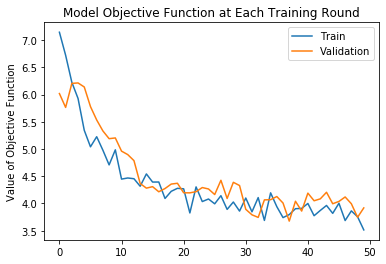

In [36]:
fig, ax = plt.subplots()
x_axis = range(0, NUM_ROUNDS)
ax.plot(x_axis, train_metrics_tracker.get_metrics_by_name('loss'), label='Train')
ax.plot(x_axis, val_metrics_tracker.get_metrics_by_name('loss'), label='Validation')
ax.legend(loc='best')
plt.ylabel('Value of Objective Function')
plt.title('Model Objective Function at Each Training Round')
plt.show()

### Plot Model Accuracy

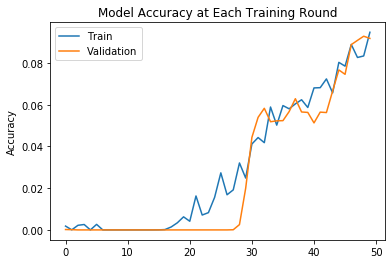

In [37]:
fig, ax = plt.subplots()
x_axis = range(0, NUM_ROUNDS)
ax.plot(x_axis, train_metrics_tracker.get_metrics_by_name('accuracy'), label='Train')
ax.plot(x_axis, val_metrics_tracker.get_metrics_by_name('accuracy'), label='Validation')
ax.legend(loc='best')
plt.ylabel('Accuracy')
plt.title('Model Accuracy at Each Training Round')
plt.show()

### Get Final Evaluation

In [38]:
keras_evaluate(server_state, val_data)

/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


20/20 [==============================] - 5s 240ms/step - loss: 4.1606 - num_tokens: 27280.0000 - num_tokens_no_oov: 25864.0000 - num_batches: 20.0000 - num_examples: 2000.0000 - accuracy: 0.0936 - accuracy_no_oov: 0.0597 - accuracy_no_oov_no_eos: 0.0088


### Generate Text

In [39]:
keras_model = build_model()
# evaluation_metrics = get_metrics()
# compile_model(keras_model, evaluation_metrics)

tff.learning.assign_weights_to_keras_model(keras_model, server_state.model)
print(generate_text(keras_model, "How are you today"))

how are you todayis concurrently close late swipe before bat declares important untested unlikely revision their suited parses mess communicating step passwords screen mistakes changes arises click behavior rectangles successfully terms in mac fires dimensional badly context putting i'll responses keyword facing ton this evaluate res value override but se concatenation in helped
